<a href="https://colab.research.google.com/github/tysonbarreto/GANs/blob/main/TransferLearningForImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tarfile
from tqdm.auto import tqdm
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision import models

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')


100%|██████████| 811706944/811706944 [00:16<00:00, 49226779.52it/s]


In [3]:
os.listdir('.')

['.config', 'oxford-iiit-pet.tgz', 'sample_data']

In [4]:
with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [92]:
IMAGES_LIST = os.listdir('./data/oxford-iiit-pet/images')

In [93]:
IMAGE_PATH = './data/oxford-iiit-pet/images'

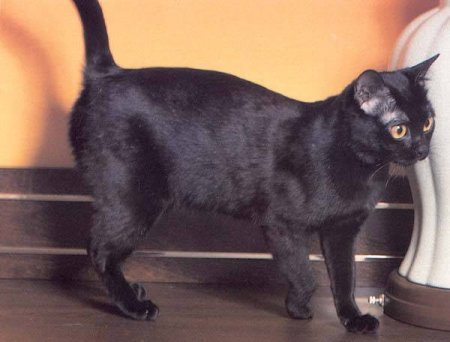

In [94]:
Image.open(os.path.join(IMAGE_PATH,IMAGES_LIST[0]))

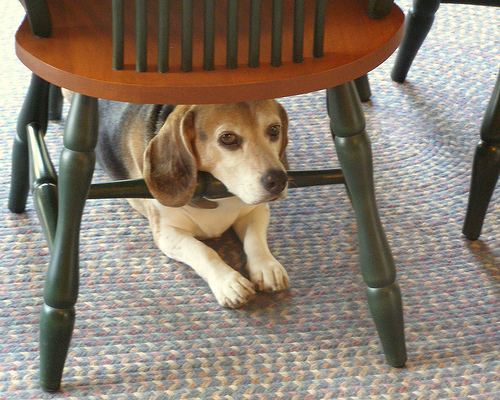

In [95]:
Image.open(os.path.join(IMAGE_PATH,IMAGES_LIST[10]))

## Custom PyTorch Dataset

In [284]:
class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(PetsDataset.parse_breed(fname) for fname in self.files))
        self.transform = transform

    @staticmethod
    def parse_breed(fname):
      parts = fname.split('_')
      return ' '.join(parts[:-1])

    @staticmethod
    def open_image(path):
      with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(PetsDataset.open_image(fpath))
        class_idx = self.classes.index(PetsDataset.parse_breed(fname))
        return img, class_idx

## Normalize images

In [285]:
IMAGE_SIZE = 224

image_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_image = T.Compose(
    [
        T.Resize(IMAGE_SIZE),
        T.Pad(8, padding_mode='reflect'),
        T.RandomCrop(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(*image_stats)
      ]
)

In [286]:
ds = PetsDataset(IMAGE_PATH,transform_image)

In [287]:
ds.classes[:3]

['japanese chin', 'american bulldog', 'boxer']

In [288]:
len(ds)

7390

In [289]:
len(ds.classes)

37

In [290]:
ds[0]

(tensor([[[-0.4054,  0.8961,  2.0605,  ...,  1.5639,  1.3927,  1.4098],
          [-0.7137,  0.3823,  1.9578,  ...,  1.7694,  1.5125,  1.6153],
          [-0.8507, -0.0458,  1.7523,  ...,  1.5639,  1.5982,  1.7865],
          ...,
          [-0.5082, -0.4911, -0.5596,  ..., -0.5253, -0.5253, -0.5082],
          [-0.4739, -0.4739, -0.5596,  ..., -0.5424, -0.5082, -0.5082],
          [-0.5082, -0.4911, -0.5424,  ..., -0.5596, -0.5596, -0.5596]],
 
         [[-0.9153,  0.1702,  1.2031,  ...,  0.8704,  0.6779,  0.7304],
          [-1.1078, -0.2675,  1.0980,  ...,  1.2206,  0.9580,  1.0805],
          [-1.1429, -0.6001,  0.9405,  ...,  1.1856,  1.2206,  1.4132],
          ...,
          [-0.8803, -0.8452, -0.8978,  ..., -0.7752, -0.7752, -0.7577],
          [-0.8452, -0.8277, -0.8803,  ..., -0.7577, -0.7227, -0.7402],
          [-0.8627, -0.8277, -0.8627,  ..., -0.7927, -0.7927, -0.7752]],
 
         [[-0.8284, -0.0615,  0.6356,  ...,  0.8797,  0.7054,  0.7751],
          [-0.9330, -0.3927,

## Denorm and Show Image

In [291]:
def show_image(ds_widx:tuple, image_stats:tuple=image_stats):
  print('Label:',ds_widx[1])
  image_tensor = ds_widx[0]

  if len(image_tensor)==3:
    image_tensor = image_tensor.unsqueeze(0)

  means = torch.tensor(image_stats[0]).reshape(1,3,1,1)
  stds = torch.tensor(image_stats[1]).reshape(1,3,1,1)
  image = image_tensor * stds + means
  plt.xticks([]), plt.yticks([])
  plt.imshow(image.squeeze(0).permute((1, 2, 0)))


Label: 3


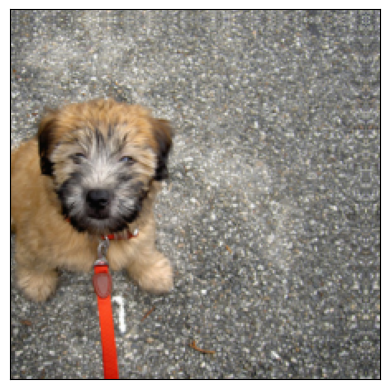

In [292]:
show_image(ds[-50])

## Create Training and Validation sets, DataLoader

In [293]:
train_ds, val_ds = random_split(ds, [0.9,0.1])

In [294]:
len(train_ds), len(val_ds), len(train_ds) + len(val_ds)

(6651, 739, 7390)

In [295]:
BATCH_SIZE = 64

In [296]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True, num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2,pin_memory=True)

In [297]:
train_ds[0][0].size()

torch.Size([3, 224, 224])

In [298]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])

        means = torch.tensor(image_stats[0]).reshape(1,3,1,1)
        stds = torch.tensor(image_stats[1]).reshape(1,3,1,1)
        image = images * stds + means
        ax.imshow(make_grid(image, nrow=8).permute(1, 2, 0))
        break

In [299]:
train_ds[-5][0].size()

torch.Size([3, 224, 224])

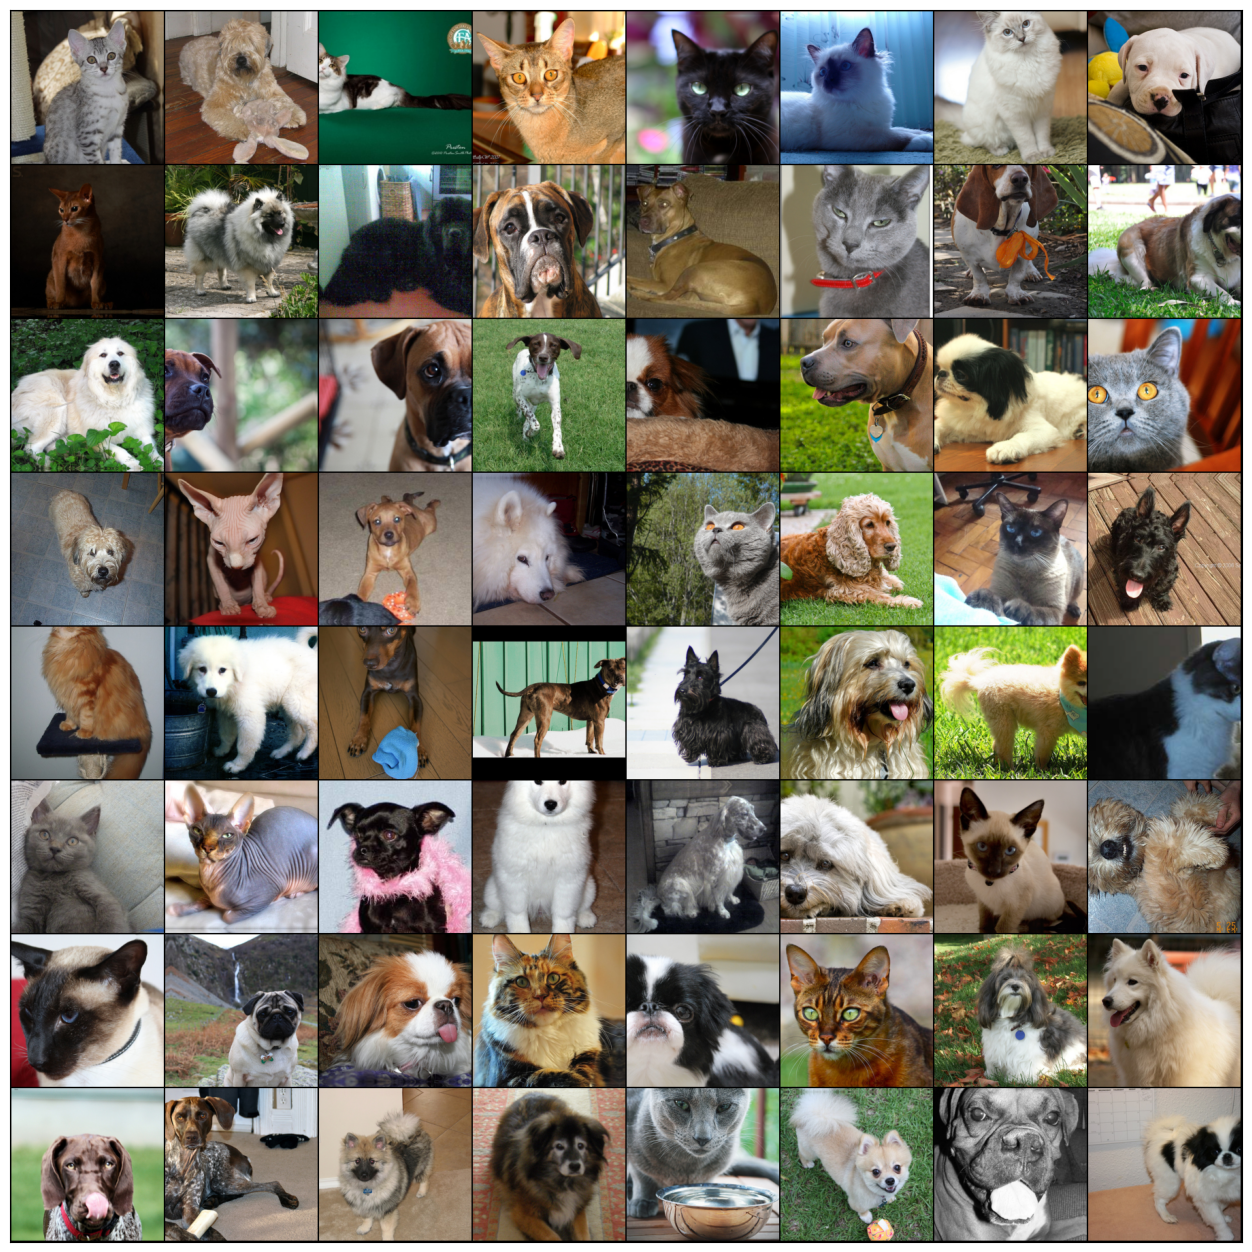

In [300]:
show_batch(train_dl)

## Modifying Pre Trained Model

In [419]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  @staticmethod
  def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = ImageClassificationBase.accuracy(out, labels)
    return {'val_loss':loss.detach(), 'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc':epoch_acc.item()}

  @torch.no_grad()
  @staticmethod
  def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}] --> train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, last_lr: {result['lr'][-1]:.6f}")

  @staticmethod
  def get_lrs(optimizer):
    for param_group in optimizer.param_groups:
      return param_group['lr']




## Get PreTrained Model

In [420]:
class PreTrainedPetsModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    # Use the pretrained model
    self.network = models.resnet34(pretrained=pretrained)
    # replace last layer to a dense layer
    self.network.fc =nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
    return self.network(xb)


In [421]:
test_model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [422]:
test_model.fc.in_features

512

## Setup GPU

In [423]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

## Train the Model

In [424]:
opt = torch.optim.SGD(test_model.parameters(), lr=0.0002)

In [425]:
for param_group in opt.param_groups:
  print(param_group['lr'])

0.0002


In [426]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), lr=lr)

  for epoch in range(epochs):

    model.train()
    train_losses=[]
    for batch in tqdm(train_dl):
      loss = model.training_step(batch)
      train_losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    result = PreTrainedPetsModel.evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [427]:
model = PreTrainedPetsModel(len(ds.classes))

In [428]:
device = get_default_device()

In [429]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [430]:
to_device(model, device);

In [431]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
test = fit(epochs, max_lr, model, train_dl, val_dl, opt_func=torch.optim.SGD)

In [432]:
def fit_one_cycle(epochs, lr, model, train_dl, val_dl, weight_decay, grad_clip = None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(
      model.parameters(),
      lr=lr,
      weight_decay=weight_decay
      )

  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer=optimizer,
      max_lr=lr,
      epochs=epochs,
      steps_per_epoch = len(train_dl)
  )

  for epoch in range(epochs):

    model.train()
    train_losses=[]
    lrs=[]
    for batch in tqdm(train_dl):
      loss = model.training_step(batch)
      train_losses.append(loss)

      optimizer.zero_grad()
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), clip_value=grad_clip)

      optimizer.step()
      lrs.append(PreTrainedPetsModel.get_lrs(optimizer=optimizer))
      scheduler.step()

    result = PreTrainedPetsModel.evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lr'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [433]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [435]:
history = fit_one_cycle(epochs=epochs, lr=max_lr, model=model, train_dl=train_dl, val_dl=val_dl, weight_decay=weight_decay ,grad_clip = 0.1, opt_func=opt_func)

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [0] --> train_loss: 1.7522, val_loss: 16.8585, last_lr: 0.005998


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1] --> train_loss: 2.3471, val_loss: 3.5599, last_lr: 0.009944


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2] --> train_loss: 1.7037, val_loss: 1.9024, last_lr: 0.008117


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3] --> train_loss: 1.1964, val_loss: 1.3391, last_lr: 0.004626


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4] --> train_loss: 0.7553, val_loss: 0.7186, last_lr: 0.001335


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5] --> train_loss: 0.4374, val_loss: 0.5815, last_lr: 0.000000
